<a href="https://colab.research.google.com/github/firarru/Text-Mining/blob/main/Tugas_3_Kelompok_4_Text_Mining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Package**

In [1]:
import pandas as pd
import re
import ast
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import FreqDist
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# **Read Data**

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/rizalespe/Dataset-Sentimen-Analisis-Bahasa-Indonesia/refs/heads/master/dataset_tweet_sentimen_tayangan_tv.csv')
df.head()

,Id,Sentiment,Acara TV,Jumlah Retweet,Text Tweet
0,1,positive,HitamPutihTransTV,12,"Undang @N_ShaniJKT48 ke hitamputih, pemenang S..."
1,2,positive,HitamPutihTransTV,6,Selamat berbuka puasa Semoga amal ibadah hari ...
2,3,positive,HitamPutihTransTV,9,"Ada nih di trans7 hitam putih, dia dpt penghar..."
3,4,positive,HitamPutihTransTV,2,selamat ya mas @adietaufan masuk hitamputih
4,5,positive,HitamPutihTransTV,1,Asiknya nonton Hitam Putih Trans7


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Id              400 non-null    int64 
 1   Sentiment       400 non-null    object
 2   Acara TV        400 non-null    object
 3   Jumlah Retweet  400 non-null    int64 
 4   Text Tweet      400 non-null    object
dtypes: int64(2), object(3)
memory usage: 15.8+ KB


In [4]:
df = df[['Sentiment', 'Text Tweet']]
df.shape

(400, 2)

Sentiment
positive    200
negative    200
Name: count, dtype: int64


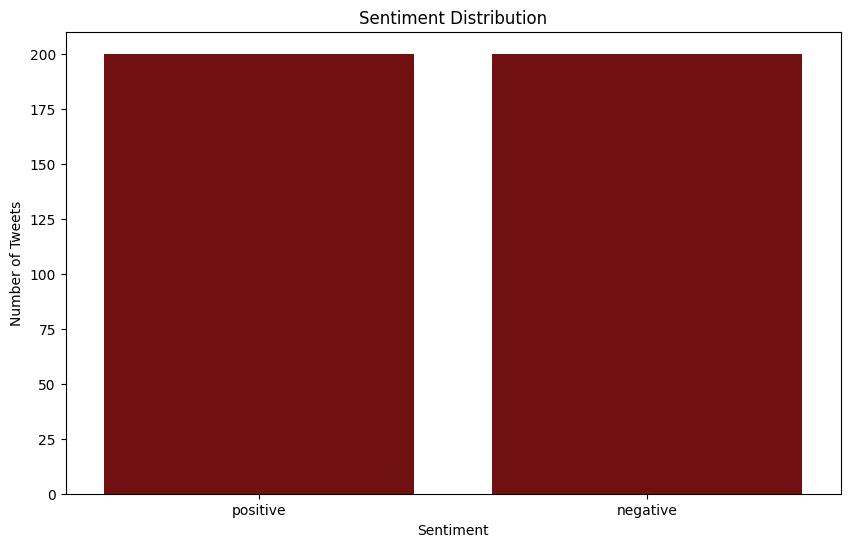

In [5]:
sentiment_counts = df['Sentiment'].value_counts()
print(sentiment_counts)

plt.figure(figsize=(10, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, color='maroon')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Number of Tweets')
plt.show()

## A. Case Folding

In [6]:
def convert_text(text):
    try:
        teks = ast.literal_eval(text)
        return " ".join([word.lower() for word in teks]) # Convert to lowercase here
    except (ValueError, SyntaxError):
        if isinstance(text, str):
          return " ".join([word.lower() for word in text.split()]) # Handle string cases
        return text # Return original text if conversion fails

df['Text Tweet'] = df['Text Tweet'].apply(convert_text)

In [7]:
# df['Text Tweet'].tolist()

## B. Cleaning

In [8]:
import re

def clean_text(text):
    text = re.sub(r'#\w+', '', text) #remove hashtag
    text = re.sub(r'\b\w*\d\w*\b', '', text) #remove words with numbers in the middle
    text = re.sub(r'@\w+', '', text) #remove mentions (@username)
    text = re.sub(r'https?://\S+|www\.\S+', '', text) #remove URLs
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text) #remove special characters (keep only alphanumeric and spaces)
    return text

df['Text Tweet'] = df['Text Tweet'].apply(clean_text)

In [9]:
df['Text Tweet'].tolist()[:30]

['undang  ke hitamputih pemenang ssk  harusnya  ini lebih layak di undang karena prestasinya',
 'selamat berbuka puasa semoga amal ibadah hari ni diterima allah ',
 'ada nih di  hitam putih dia dpt penghargaan juga di norwegia ',
 'selamat ya mas  masuk hitamputih',
 'asiknya nonton hitam putih ',
 ' acara paling komplit dan menarik apalagi ada hitam putih',
 'hitam putih  inspiratif banget',
 'suka banget dengan acara hitam putih',
 'keren lu bro ',
 'tadi ada yg liat hitam putih di  ga ada sanggu ganteng',
 'cinta mengikat silaturahmi di hati     ',
 'terima kasih pak sudah mau membantu kami untuk menyekolahkan adik saya ',
 'semoga lancar ',
 ' hitam putih terbaik ',
 'acara hitam putih paling bagus buat di lihat',
 ' undang  di acara hitam putih yadia jebolan dangdut academi pinter nyanyi lagu india suaranya keren',
 'bagus rancangan seperti ini di  hitamputih  dakwah hiburannya terima kasih ustadz wijayanto',
 'wah kapan rihanna bisa jadi bintang tamu hitam putih kayak di  jadi ka

In [10]:
df = df[['Text Tweet', 'Sentiment']]
df.head(20)

,Text Tweet,Sentiment
0,undang ke hitamputih pemenang ssk harusnya ...,positive
1,selamat berbuka puasa semoga amal ibadah hari ...,positive
2,ada nih di hitam putih dia dpt penghargaan ju...,positive
3,selamat ya mas masuk hitamputih,positive
4,asiknya nonton hitam putih,positive
5,acara paling komplit dan menarik apalagi ada ...,positive
6,hitam putih inspiratif banget,positive
7,suka banget dengan acara hitam putih,positive
8,keren lu bro,positive
9,tadi ada yg liat hitam putih di ga ada sanggu...,positive


## C. Tokenizing

In [11]:
#Menggunakan Split
df['Text Tweet'].apply(lambda x: x.split())

,Text Tweet
0,"[undang, ke, hitamputih, pemenang, ssk, harusn..."
1,"[selamat, berbuka, puasa, semoga, amal, ibadah..."
2,"[ada, nih, di, hitam, putih, dia, dpt, penghar..."
3,"[selamat, ya, mas, masuk, hitamputih]"
4,"[asiknya, nonton, hitam, putih]"
...,...
395,"[ini, apa, banget, deh, gw, paling, kesel, klo..."
396,"[orang, miskin, semakin, miskin, klo, sekolah,..."
397,"[ga, boleh, emosi, cepat, tua, nonton, lihat, ..."
398,"[dr, penampilan, saja, kyk, preman, taunya, bk..."


In [12]:
#Menggunakan tokenize
nltk.download('punkt_tab')
df['Tokenize'] = df['Text Tweet'].apply(word_tokenize)
df

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


,Text Tweet,Sentiment,Tokenize
0,undang ke hitamputih pemenang ssk harusnya ...,positive,"[undang, ke, hitamputih, pemenang, ssk, harusn..."
1,selamat berbuka puasa semoga amal ibadah hari ...,positive,"[selamat, berbuka, puasa, semoga, amal, ibadah..."
2,ada nih di hitam putih dia dpt penghargaan ju...,positive,"[ada, nih, di, hitam, putih, dia, dpt, penghar..."
3,selamat ya mas masuk hitamputih,positive,"[selamat, ya, mas, masuk, hitamputih]"
4,asiknya nonton hitam putih,positive,"[asiknya, nonton, hitam, putih]"
...,...,...,...
395,ini apa banget deh gw paling kesel klo pada d...,negative,"[ini, apa, banget, deh, gw, paling, kesel, klo..."
396,orang miskin semakin miskin klo sekolah melaku...,negative,"[orang, miskin, semakin, miskin, klo, sekolah,..."
397,ga boleh emosi cepat tua nonton lihat bapak ...,negative,"[ga, boleh, emosi, cepat, tua, nonton, lihat, ..."
398,dr penampilan saja kyk preman taunya bkin kisr...,negative,"[dr, penampilan, saja, kyk, preman, taunya, bk..."


## D. Menghapus Stopword

In [13]:
nltk.download('stopwords')
stop_words = set(stopwords.words('indonesian'))
df['Stopword'] = df['Tokenize'].apply(lambda x: [word for word in x if word.lower() not in stop_words])
df

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Text Tweet,Sentiment,Tokenize,Stopword
0,undang ke hitamputih pemenang ssk harusnya ...,positive,"[undang, ke, hitamputih, pemenang, ssk, harusn...","[undang, hitamputih, pemenang, ssk, layak, und..."
1,selamat berbuka puasa semoga amal ibadah hari ...,positive,"[selamat, berbuka, puasa, semoga, amal, ibadah...","[selamat, berbuka, puasa, semoga, amal, ibadah..."
2,ada nih di hitam putih dia dpt penghargaan ju...,positive,"[ada, nih, di, hitam, putih, dia, dpt, penghar...","[nih, hitam, putih, dpt, penghargaan, norwegia]"
3,selamat ya mas masuk hitamputih,positive,"[selamat, ya, mas, masuk, hitamputih]","[selamat, ya, mas, masuk, hitamputih]"
4,asiknya nonton hitam putih,positive,"[asiknya, nonton, hitam, putih]","[asiknya, nonton, hitam, putih]"
...,...,...,...,...
395,ini apa banget deh gw paling kesel klo pada d...,negative,"[ini, apa, banget, deh, gw, paling, kesel, klo...","[banget, deh, gw, kesel, klo, debat, pake, emo..."
396,orang miskin semakin miskin klo sekolah melaku...,negative,"[orang, miskin, semakin, miskin, klo, sekolah,...","[orang, miskin, miskin, klo, sekolah, pungutan..."
397,ga boleh emosi cepat tua nonton lihat bapak ...,negative,"[ga, boleh, emosi, cepat, tua, nonton, lihat, ...","[ga, emosi, cepat, tua, nonton, lihat, emosi, ..."
398,dr penampilan saja kyk preman taunya bkin kisr...,negative,"[dr, penampilan, saja, kyk, preman, taunya, bk...","[dr, penampilan, kyk, preman, taunya, bkin, ki..."


In [14]:
custom_stopword = ['dpt', 'yg', 'ga', 'kyk', 'nya', 'nih', 'deh', 'dr', 'klo', 'utk', 'tdk',
                   'dg', 'bs', 'krn', 'org', 'mw', 'km', 'sbg', 'g', 'dgn', 'ttg', 'lg', 'jd', 'jg']
df['Stopword'] = df['Stopword'].apply(lambda x: [word for word in x if word.lower() not in custom_stopword])
df

,Text Tweet,Sentiment,Tokenize,Stopword
0,undang ke hitamputih pemenang ssk harusnya ...,positive,"[undang, ke, hitamputih, pemenang, ssk, harusn...","[undang, hitamputih, pemenang, ssk, layak, und..."
1,selamat berbuka puasa semoga amal ibadah hari ...,positive,"[selamat, berbuka, puasa, semoga, amal, ibadah...","[selamat, berbuka, puasa, semoga, amal, ibadah..."
2,ada nih di hitam putih dia dpt penghargaan ju...,positive,"[ada, nih, di, hitam, putih, dia, dpt, penghar...","[hitam, putih, penghargaan, norwegia]"
3,selamat ya mas masuk hitamputih,positive,"[selamat, ya, mas, masuk, hitamputih]","[selamat, ya, mas, masuk, hitamputih]"
4,asiknya nonton hitam putih,positive,"[asiknya, nonton, hitam, putih]","[asiknya, nonton, hitam, putih]"
...,...,...,...,...
395,ini apa banget deh gw paling kesel klo pada d...,negative,"[ini, apa, banget, deh, gw, paling, kesel, klo...","[banget, gw, kesel, debat, pake, emosi, gini]"
396,orang miskin semakin miskin klo sekolah melaku...,negative,"[orang, miskin, semakin, miskin, klo, sekolah,...","[orang, miskin, miskin, sekolah, pungutan, liar]"
397,ga boleh emosi cepat tua nonton lihat bapak ...,negative,"[ga, boleh, emosi, cepat, tua, nonton, lihat, ...","[emosi, cepat, tua, nonton, lihat, emosi, bicara]"
398,dr penampilan saja kyk preman taunya bkin kisr...,negative,"[dr, penampilan, saja, kyk, preman, taunya, bk...","[penampilan, preman, taunya, bkin, kisruh, per..."


## E. Stemming

In [15]:
pip install Sastrawi

In [16]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

factory = StemmerFactory()
stemmer = factory.create_stemmer()

df['Clean'] = df['Stopword'].apply(lambda x: [stemmer.stem(word) for word in x])
df

,Text Tweet,Sentiment,Tokenize,Stopword,Clean
0,undang ke hitamputih pemenang ssk harusnya ...,positive,"[undang, ke, hitamputih, pemenang, ssk, harusn...","[undang, hitamputih, pemenang, ssk, layak, und...","[undang, hitamputih, menang, ssk, layak, undan..."
1,selamat berbuka puasa semoga amal ibadah hari ...,positive,"[selamat, berbuka, puasa, semoga, amal, ibadah...","[selamat, berbuka, puasa, semoga, amal, ibadah...","[selamat, buka, puasa, moga, amal, ibadah, ni,..."
2,ada nih di hitam putih dia dpt penghargaan ju...,positive,"[ada, nih, di, hitam, putih, dia, dpt, penghar...","[hitam, putih, penghargaan, norwegia]","[hitam, putih, harga, norwegia]"
3,selamat ya mas masuk hitamputih,positive,"[selamat, ya, mas, masuk, hitamputih]","[selamat, ya, mas, masuk, hitamputih]","[selamat, ya, mas, masuk, hitamputih]"
4,asiknya nonton hitam putih,positive,"[asiknya, nonton, hitam, putih]","[asiknya, nonton, hitam, putih]","[asiknya, nonton, hitam, putih]"
...,...,...,...,...,...
395,ini apa banget deh gw paling kesel klo pada d...,negative,"[ini, apa, banget, deh, gw, paling, kesel, klo...","[banget, gw, kesel, debat, pake, emosi, gini]","[banget, gw, kesel, debat, pake, emosi, gin]"
396,orang miskin semakin miskin klo sekolah melaku...,negative,"[orang, miskin, semakin, miskin, klo, sekolah,...","[orang, miskin, miskin, sekolah, pungutan, liar]","[orang, miskin, miskin, sekolah, pungut, liar]"
397,ga boleh emosi cepat tua nonton lihat bapak ...,negative,"[ga, boleh, emosi, cepat, tua, nonton, lihat, ...","[emosi, cepat, tua, nonton, lihat, emosi, bicara]","[emosi, cepat, tua, nonton, lihat, emosi, bicara]"
398,dr penampilan saja kyk preman taunya bkin kisr...,negative,"[dr, penampilan, saja, kyk, preman, taunya, bk...","[penampilan, preman, taunya, bkin, kisruh, per...","[tampil, preman, tau, bkin, kisruh, usak]"


In [17]:
df['Clean'] = df['Clean'].apply(lambda x: ' '.join(eval(x)) if isinstance(x, str) and x.startswith('[') else ' '.join(x) if isinstance(x, list) else '')

In [18]:
df['Clean']

,Clean
0,undang hitamputih menang ssk layak undang pres...
1,selamat buka puasa moga amal ibadah ni terima ...
2,hitam putih harga norwegia
3,selamat ya mas masuk hitamputih
4,asiknya nonton hitam putih
...,...
395,banget gw kesel debat pake emosi gin
396,orang miskin miskin sekolah pungut liar
397,emosi cepat tua nonton lihat emosi bicara
398,tampil preman tau bkin kisruh usak


# F. Freq & Dist

[('mata', 63), ('najwa', 60), ('hitam', 40), ('putih', 39), ('acara', 36), ('nonton', 29), ('keren', 29), ('orang', 27), ('tv', 25), ('indonesia', 20), ('ahok', 19), ('banget', 18), ('metro', 18), ('inspirasi', 17), ('malam', 16), ('aja', 16), ('undang', 14), ('ilc', 14), ('moga', 13), ('ya', 13)]


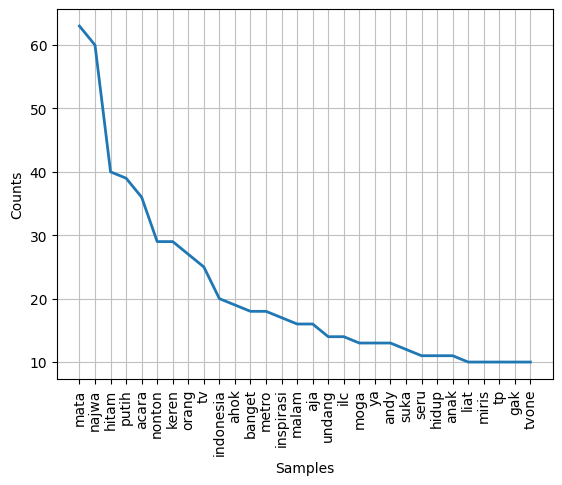

In [19]:
all_words = []
for text in df['Clean']:
    all_words.extend(text.split())

fdist = FreqDist(all_words)

print(fdist.most_common(20))

import matplotlib.pyplot as plt
fdist.plot(30,cumulative=False)
plt.show()

# G. TF-IDF

In [20]:
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(df['Clean'])
join = " ".join(df['Clean'])
tfidf = vectorizer.fit_transform([join])
feature_names = vectorizer.get_feature_names_out()
df_tfidf = pd.DataFrame(tfidf.toarray(), columns=feature_names)
df_tfidf.T.sort_values(by=0, ascending=False)

,0
mata,0.400438
najwa,0.381370
hitam,0.254246
putih,0.247890
acara,0.228822
...,...
karakter,0.006356
karni,0.006356
karunia,0.006356
kataberkuasa,0.006356


In [21]:
df_tfidf

,aa,abang,abas,abi,abis,abraham,academi,acara,acung,adem,...,wna,woidjojayanto,ya,yaampun,yadia,yag,younglex,yuk,zaitun,zhonk
0,0.019068,0.006356,0.006356,0.006356,0.012712,0.012712,0.006356,0.228822,0.006356,0.019068,...,0.006356,0.006356,0.08263,0.006356,0.006356,0.012712,0.006356,0.025425,0.006356,0.006356


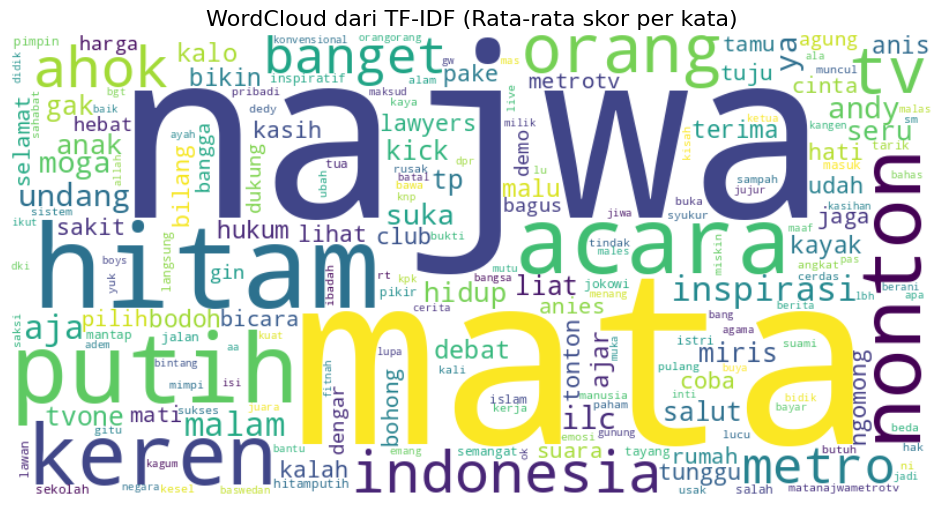

In [22]:
from wordcloud import WordCloud

word_scores = {word: score for word, score in zip(feature_names, tfidf.toarray()[0])}

wc = WordCloud(width=800, height=400, background_color='white')
wc.generate_from_frequencies(word_scores)

plt.figure(figsize=(12, 6))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud dari TF-IDF (Rata-rata skor per kata)', fontsize=16)
plt.show()

# H. Split Data

In [23]:
X = df['Clean']
y = df['Sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # 80% train, 20% test

In [24]:
print("Training data :", X_train.shape)
print("Testing data :", X_test.shape)

Training data : (320,)
Testing data : (80,)


# I. Naive Bayes

In [25]:
# TF-IDF Split Data
vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [26]:
clf = MultinomialNB()
clf.fit(X_train_vec, y_train)

y_pred_nb = clf.predict(X_test_vec)

In [27]:
nb_df = pd.DataFrame({'Kalimat': X_test, 'Sentimen Aktual': y_test, 'Sentimen Prediksi': y_pred_nb})
nb_df[:10]

,Kalimat,Sentimen Aktual,Sentimen Prediksi
209,gila daki gunung mantap jiwa,positive,positive
280,orang belanda aja peduli indonesia d daerah is...,negative,negative
33,suka banget episode hitam putih malam,positive,positive
210,sayang alam niscaya alam sayang,positive,positive
93,kaya gin negara inti gk tuju usaha kaya gin,negative,positive
84,tau buruk kau pergi,negative,negative
329,tjokro rumah teladan senioritas hidup kerdil,positive,negative
94,gak gadget mahal nipu gk argonya argo kuda gak...,negative,negative
266,kalo antem telor busuk ketek,negative,negative
126,sabar nunggu,positive,negative


In [28]:
accuracy = accuracy_score(y_test, y_pred_nb)
print(f"Accuracy: {accuracy}")

Accuracy: 0.8375


In [29]:
print(classification_report(y_test, y_pred_nb))

              precision    recall  f1-score   support

    negative       0.89      0.79      0.84        43
    positive       0.79      0.89      0.84        37

    accuracy                           0.84        80
   macro avg       0.84      0.84      0.84        80
weighted avg       0.84      0.84      0.84        80



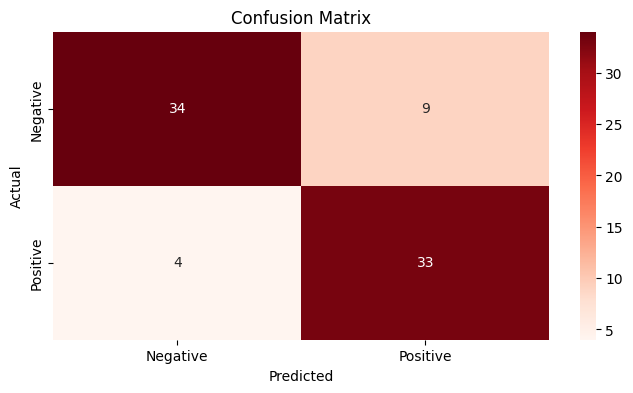

In [30]:
cm = confusion_matrix(y_test, y_pred_nb)
plt.figure(figsize=(8, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# J. SVM

In [31]:
from sklearn.svm import SVC

svm_classifier = SVC(kernel='linear')
svm_classifier.fit(X_train_vec, y_train)

svm_pred = svm_classifier.predict(X_test_vec)

In [32]:
svm_df = pd.DataFrame({'Kalimat': X_test, 'Sentimen Aktual': y_test, 'Sentimen Prediksi': svm_pred})
svm_df[:10]

,Kalimat,Sentimen Aktual,Sentimen Prediksi
209,gila daki gunung mantap jiwa,positive,positive
280,orang belanda aja peduli indonesia d daerah is...,negative,negative
33,suka banget episode hitam putih malam,positive,positive
210,sayang alam niscaya alam sayang,positive,negative
93,kaya gin negara inti gk tuju usaha kaya gin,negative,negative
84,tau buruk kau pergi,negative,negative
329,tjokro rumah teladan senioritas hidup kerdil,positive,negative
94,gak gadget mahal nipu gk argonya argo kuda gak...,negative,negative
266,kalo antem telor busuk ketek,negative,negative
126,sabar nunggu,positive,negative


In [33]:
svm_accuracy = accuracy_score(y_test, svm_pred)
print(f"SVM Accuracy: {svm_accuracy}")

SVM Accuracy: 0.875


In [34]:
print(classification_report(y_test, svm_pred))

              precision    recall  f1-score   support

    negative       0.85      0.93      0.89        43
    positive       0.91      0.81      0.86        37

    accuracy                           0.88        80
   macro avg       0.88      0.87      0.87        80
weighted avg       0.88      0.88      0.87        80



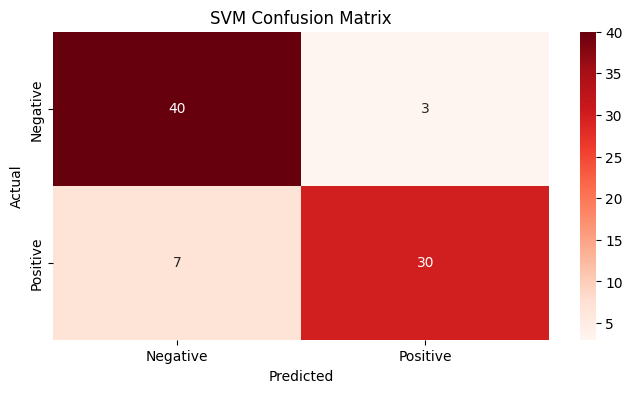

In [35]:
# Confusion Matrix
svm_cm = confusion_matrix(y_test, svm_pred)
plt.figure(figsize=(8, 4))
sns.heatmap(svm_cm, annot=True, fmt='d', cmap='Reds',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('SVM Confusion Matrix')
plt.show()